In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score , confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import joblib
import os


e:\Bureau\imaneeeee\Credit-Card-Default-Prediction\proENv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
df = pd.read_csv("data/2_data_clean.csv")

In [4]:
TARGET = "default.payment.next.month"

X = df.drop(columns=[TARGET])
y = df[TARGET]

In [5]:
print(X.shape, y.value_counts())

(30000, 22) default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64


In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [8]:
X_train.shape

(24000, 22)

In [7]:
X_val.shape

(6000, 22)

In [9]:
y_train.value_counts(normalize=True)

default.payment.next.month
0    0.778792
1    0.221208
Name: proportion, dtype: float64

In [10]:
y_val.value_counts(normalize=True)

default.payment.next.month
0    0.778833
1    0.221167
Name: proportion, dtype: float64

In [11]:
classes = y_train.unique()

In [12]:
features = X_train.columns  # الأعمدة المستخدمة للتدريب

X_val = X_val[features]  

In [13]:
X_val 

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_RATIO,BILL_STD,NB_LATE_PAYMENTS,BILL_TREND,PAY_TREND
6907,50000.0,1,2,2,46,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,8.152774,7.749753,7.475906,7.952263,0.694825,9.197427,0,7.110696,0.000000
24575,150000.0,1,1,1,31,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,9.366917,10.308986,0.940736,8.849686,0,0.000000,10.308986
26766,50000.0,1,2,2,25,0.000000,0.000000,0.0,0.0,0.0,...,7.520235,7.696667,7.601402,7.496097,7.620215,0.038636,7.014899,0,7.877776,5.476464
2156,290000.0,2,1,2,25,0.000000,0.000000,0.0,0.0,0.0,...,9.259226,9.210440,9.615872,8.967632,10.057667,0.048963,10.441589,0,0.000000,9.028099
3179,500000.0,2,2,1,27,0.000000,0.000000,0.0,0.0,0.0,...,9.516942,9.210440,9.210440,9.210440,10.138757,0.795327,7.282516,0,0.000000,9.637045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8836,150000.0,2,4,2,27,0.000000,0.000000,0.0,0.0,0.0,...,11.092504,9.921769,3.258097,9.246094,8.493310,0.636952,9.971021,0,0.000000,0.000000
1259,50000.0,1,1,2,24,1.098612,1.098612,0.0,0.0,0.0,...,7.640123,6.542472,6.985642,6.552508,6.912743,0.027078,9.666695,2,0.000000,6.912743
27309,220000.0,1,1,2,34,0.000000,0.000000,0.0,0.0,0.0,...,8.449984,9.162305,11.113275,0.000000,0.000000,0.281035,10.915955,0,11.488827,0.000000
29583,120000.0,1,1,2,26,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,9.254070,0.000000,0.000000,0.602250,8.320102,0,0.000000,0.000000


In [14]:
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

In [15]:
weights

array([0.64202022, 2.26031268])

In [16]:
hey = np.array([0.64202022, 2.26031268*2])

In [17]:
class_weights = dict(zip(classes, hey))

In [18]:
class_weights 

{np.int64(0): np.float64(0.64202022), np.int64(1): np.float64(4.52062536)}

In [19]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight=class_weights,
    random_state=42
)

lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict_proba(X_val)[:, 1]
lgb_auc = roc_auc_score(y_val, lgb_pred)

print("LightGBM ROC-AUC:", lgb_auc)

[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2694
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666667 -> initscore=0.693147
[LightGBM] [Info] Start training from score 0.693147
LightGBM ROC-AUC: 0.7756691545702348


In [20]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_pred)

print("XGBoost ROC-AUC:", xgb_auc)


XGBoost ROC-AUC: 0.7769327266209337


In [21]:
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=class_weights,
    verbose=0,
    random_state=42
)

cat_model.fit(X_train, y_train)

cat_pred = cat_model.predict_proba(X_val)[:, 1]
cat_auc = roc_auc_score(y_val, cat_pred)

print("CatBoost ROC-AUC:", cat_auc)


CatBoost ROC-AUC: 0.7762243006087174


In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [23]:
n_features = X_train_scaled.shape[1]
nn_model = Sequential([
    Dense(32, activation='relu', input_shape=(n_features,)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

e:\Bureau\imaneeeee\Credit-Card-Default-Prediction\proENv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [25]:
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

In [26]:
nn_model.fit(X_train_scaled, 
             y_train, validation_data=(X_val_scaled, y_val),
             epochs=50, 
             batch_size=32, 
             class_weight=class_weights,
             callbacks=[early_stop], verbose=0)


e:\Bureau\imaneeeee\Credit-Card-Default-Prediction\proENv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  current = self.get_monitor_value(logs)


In [27]:
# Predictions
nn_pred = nn_model.predict(X_val_scaled)[:,0]

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [28]:
nn_auc = roc_auc_score(y_val, nn_pred)

print("Neural Network ROC-AUC:", nn_auc)

Neural Network ROC-AUC: 0.7530831367678261


In [29]:
print("=== MODEL PERFORMANCE ===")
print("LightGBM AUC : ", lgb_auc)
print("XGBoost AUC  : ",xgb_auc)
print("CatBoost AUC : ",cat_auc)
print("Neural Network ROC-AUC:", nn_auc)

=== MODEL PERFORMANCE ===
LightGBM AUC :  0.7756691545702348
XGBoost AUC  :  0.7769327266209337
CatBoost AUC :  0.7762243006087174
Neural Network ROC-AUC: 0.7530831367678261


In [30]:
X_val['lgb_pred'] = lgb_pred
X_val['xgb_pred'] = xgb_pred
X_val['cat_pred'] = cat_pred
X_val['nn_pred'] = nn_pred
stacking_df = X_val.copy()

In [32]:
X_meta = stacking_df
y_meta = y_val.reset_index(drop=True)


In [33]:
meta_model = Ridge()
meta_model.fit(X_meta, y_meta)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [34]:
meta_pred = meta_model.predict(X_meta)
meta_auc = roc_auc_score(y_meta, meta_pred)
print("Meta-Model ROC-AUC:", meta_auc)

Meta-Model ROC-AUC: 0.7786532358684491


Confusion Matrix (Meta-Model):
[[4447  226]
 [ 858  469]]

Classification Report (Meta-Model):
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



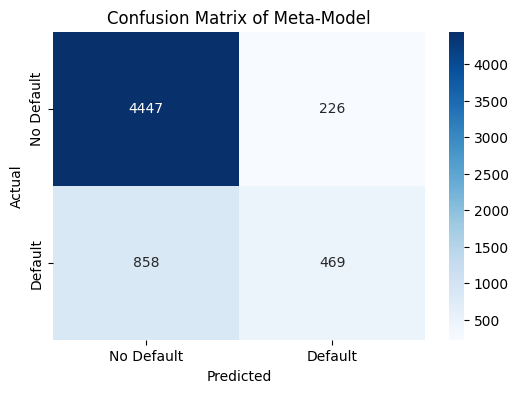

In [36]:
#  Confusion Matrix for Meta-Model

meta_class = np.round(meta_pred).astype(int)  # 0.5 threshold

cm = confusion_matrix(y_meta, meta_class)
print("Confusion Matrix (Meta-Model):")
print(cm)

print("\nClassification Report (Meta-Model):")
print(classification_report(y_meta, meta_class))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Meta-Model")
plt.show()



In [38]:
stacking_df.to_csv("data/3_stacking_level1.csv", index=False)